# Assignment 6 Solutions

In [8]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from scipy.special import gamma

def q_tukey(k, v, alpha):

    qarray = []
    for k in range(2,k+1):
        print ("q_tukey: calculating k = ",k)

        dq = 0.003
        qd = np.array(np.arange(0.000,6.000,dq))

        f = []
        fs = []
        found = False

        for i in range(len(qd)):
            q = qd[i]
            prefactor = np.sqrt(2.0*np.pi)*k*(k-1)*v**(v/2.0)/(gamma(v/2.0)*2**(v/2.0-1))
            npts = 100

            xh = 6.0
            xl = 0.0
            dx = (xh-xl)/npts

            x = np.arange(xl,xh,dx)
            x = x.reshape(1,-1)
    
            ul = -6.0
            uh = 6.0
            du = (uh-ul)/npts
            
            u = np.arange(ul,uh,du)
            u = u.reshape(-1,1)
            
            phi_u = stats.norm.pdf(u)
            phi_ux = stats.norm.pdf(u-q*x)
            Phi_u = stats.norm.cdf(u)
            Phi_ux = stats.norm.cdf(u-q*x)
            phi_x = stats.norm.pdf(np.sqrt(v)*x)
            
            integrand = x**v*phi_x*phi_u*phi_ux*(Phi_u-Phi_ux)**(k-2)*du*dx
            
            #print ("U integral matrix")
            #print(u,phi_u,phi_ux,Phi_u,Phi_ux,phi_x,x**v,integrand)
        
            sumux = integrand.sum()
            
            #print ("U sum")
            #print(sumux)
            
            #print ("X sum * prefactor")
            #print (sumux*prefactor)

            f.append(sumux*prefactor)
            
            if (i>0):
                fs.append(f[i]*dq+fs[i-1])
            else:
                fs.append(f[i]*dq)

            if (fs[i]>(1-alpha) and not(found)):
                q_critical = qd[i-1] + ((1-alpha)-fs[i-1])*(qd[i]-qd[i-1])/(fs[i]-fs[i-1])
                print ("q_critical = ",q_critical)
                found = True
        
            #print(q,f[i],fs[i])
            
        qarray.append(q_critical)
        plt.scatter(q_critical,(1-alpha))
    
        f = np.array(f)
        fs = np.array(fs)
        plt.plot(qd,fs)

    qarray=np.array(qarray)
    return qarray

# Question 1

The number of miles of useful tread wear (in 1000s) was determined for tires of each of five different makes of subcompact car (factor A, with I = 5) in combination with each of four different brands of radial tires (factor B, with J = 4), resulting in IJ = 20 observations. The values SSA = 30.3, SSB = 44.4, and SSE = 59.3 were then computed. Assume that an additive model is appropriate.

(a) Test Ho: α1 = α2 = α3 = α4 = α5 = 0 (no differences in true average tire lifetime due to makes of cars) versus Ha: at least one αi ≠ 0 using a level .05 test. (Give answers accurate to 2 decimal places.)

(b) Ho: β1 = β2 = β3 = β4 = 0 (no differences in true average tire lifetime due to brands of tires) versus Ha: at least one βi ≠ 0 using a level .05 test. (Give answers accurate to 2 decimal places.)

In [23]:
a = 5
b = 4
n = 1

N = n * a * b

v_total = N - 1
v_a = a - 1
v_b = b - 1
v_error = v_total - v_a - v_b

SS_a = 30.3
SS_b = 44.9
SS_error = 59.1

SS_total = SS_a + SS_b + SS_error

MS_a = SS_a / v_a
MS_b = SS_b / v_b
MS_error = SS_error / v_error

fSN_a = MS_a / MS_error
fSN_b = MS_b / MS_error

print("F Signal/Noise A = %0.2f" % fSN_a)

alpha = 0.05

fdist_a = stats.f(v_a, v_error)
fhigh_a = fdist_a.ppf(1 - alpha)

print("Critical F-value A = %0.2f" % (fhigh_a))

if (fSN_a > 1):
    pvalue_a = (1 - fdist_a.cdf(fSN_a))
else:
    pvalue_a = fdist_a.cdf(fSN_a)
    
print("Pvalue A = %0.3f" % (pvalue_a))

print("F Signal/Noise B = %0.2f" % (fSN_b))

fdist_b = stats.f(v_b, v_error)
fhigh_b = fdist_b.ppf(1 - alpha)

print("Critical F-value B = %0.2f" % (fhigh_b))

if (fSN_b > 1):
    pvalue_b = (1 - fdist_b.cdf(fSN_b))
else:
    pvalue_b = fdist_b.cdf(fSN_b)

print("Pvalue B = %0.3f" % (pvalue_b))

F Signal/Noise A = 1.54
Critical F-value A = 3.26
Pvalue A = 0.253
F Signal/Noise B = 3.04
Critical F-value B = 3.49
Pvalue B = 0.071


# Question 2

Four different coatings are being considered for corrosion protection of metal pipe. The pipe will be buried in three different types of soil. To investigate whether the amount of corrosion depends either on the coating or on the type of soil, 12 pieces of pipe are selected. Each piece is coated with one of the four coatings and buried in one of the three types of soil for a fixed time, after which the amount of corrosion (depth of maximum pits, in .0001 in.) is determined. The data appears in the table.

(a) Assuming the validity of the additive model, carry out the ANOVA analysis using an ANOVA table to see whether the amount of corrosion depends on either the type of coating used or the type of soil. Use α = .05. (Give answers accurate to 2 decimal places and the p-values to 3 decimal places.)

(b) Compute the model parameters. (Give answers to 2 decimal places.)

In [24]:
data = np.array([[64,1,1],[50,1,2],[51,1,3],[55,2,1],[53,2,2],[47,2,3],[46,3,1],[46,3,2],[49,3,3],[52,4,1],[45,4,2],[53,4,3]])

df = pd.DataFrame(data, columns=['value', 'A', 'B'])

formula = 'value ~ C(A) + C(B)'
lm = ols(formula, df).fit()
anova_results = anova_lm(lm)
print(anova_results)

# Fail to reject both the null hypohteses for H0A and H0B; there does not appear to be a coating effect or a soil type effect

           df      sum_sq    mean_sq         F    PR(>F)
C(A)      3.0  100.250000  33.416667  1.548263  0.296370
C(B)      2.0   71.166667  35.583333  1.648649  0.268772
Residual  6.0  129.500000  21.583333       NaN       NaN


### The model parameters are simply the differences between the group averages and the overall average ($\mu$)

In [25]:
# calculate degrees of freedom

N = len(data)
v_total = N - 1
a = 4
b = 3

n = N / (a * b)

v_a = a - 1
v_b = b - 1
v_ab = v_a * v_b

v_error = v_total - v_a - v_b - v_ab

print("v_a: %i, v_b: %i, v_ab: %i, v_error: %i, v_total: %i" % (v_a, v_b, v_ab, v_error, v_total))

# averages
xbarbar = df['value'].mean()
print("xbarbar (mu) =", xbarbar)

v_a: 3, v_b: 2, v_ab: 6, v_error: 0, v_total: 11
xbarbar (mu) = 50.916666666666664


In [26]:
x_a = df.groupby(['A'])[['value']].mean()
x_a_bb = (x_a['value']-xbarbar)

print("alpha: ", x_a_bb)

alpha:  A
1    4.083333
2    0.750000
3   -3.916667
4   -0.916667
Name: value, dtype: float64


In [28]:
x_b = df.groupby(['B'])[['value']].mean()
x_b_bb = (x_b['value']-xbarbar)

print("beta: ", x_b_bb)

beta:  B
1    3.333333
2   -2.416667
3   -0.916667
Name: value, dtype: float64


# Question 3

The article "Adiabatic Humidification of Air with Water in a Packed Tower" (Chem. Eng. Prog., 1952: 362-370) reports data on gas film heat transfer coefficient (Btu/hr ft2 on °F) as a function of gas rate (factor A) and liquid rate (factor B).

(a) After constructing an ANOVA table, test at level .01 both the hypothesis of no gas-rate effect against the appropriate alternative and the hypothesis of no liquid-rate effect against the appropriate alternative. (Give answers accurate to 1 decimal place.)

(b) Use Tukey's procedure to investigate differences in expected heat transfer coefficient due to different gas rates. (Give answers accurate to 2 decimal places.)

(c) Repeat part (b) for liquid rates. (Give answers accurate to 2 decimal places.)

In [78]:
data = np.array([[200,1,1],[226,1,2],[240,1,3],[261,1,4],
                 [278,2,1],[312,2,2],[330,2,3],[381,2,4],
                 [369,3,1],[416,3,2],[462,3,3],[517,3,4],
                 [500,4,1],[575,4,2],[645,4,3],[733,4,4]])

df = pd.DataFrame(data, columns=['value', 'A', 'B'])

formula = 'value ~ C(A) + C(B)'
lm = ols(formula, df).fit()
anova_results = anova_lm(lm)
print(anova_results)

a = 4
b = 4
n = 1

N = n * a * b

v_total = N - 1
v_a = a - 1
v_b = b - 1
v_error = v_total - v_a - v_b

alpha = 0.01

fdist_a = stats.f(v_a, v_error)
fhigh_a = fdist_a.ppf(1 - alpha)
print("Critical f-value A = %0.2f" % (fhigh_a))

           df       sum_sq        mean_sq           F        PR(>F)
C(A)      3.0  324082.1875  108027.395833  105.311956  2.504972e-07
C(B)      3.0   39934.1875   13311.395833   12.976793  1.281863e-03
Residual  9.0    9232.0625    1025.784722         NaN           NaN
Critical f-value A = 6.99


Standard Error = 32.028
Original xbar =  [231.75 325.25 441.   613.25]
Sorted xbar =  [231.75 325.25 441.   613.25]
q_tukey: calculating k =  2
q_critical =  4.524647757521833
q_tukey: calculating k =  3
q_critical =  5.426582159217026
q_tukey: calculating k =  4
q_critical =  5.955182266371887
[4.52464776 5.42658216 5.95518227]
W = 190.73
[231.75, 325.25, 441.0, 613.25]
i j xbar1 xbar2 Diff Diff_comp Result
1 2 231.8 325.2 2.919  4.525 No
1 3 231.8 441.0 6.533  5.427 Yes
1 4 231.8 613.2 11.911  5.955 Yes
2 3 325.2 441.0 3.614  4.525 No
2 4 325.2 613.2 8.992  5.427 Yes
3 4 441.0 613.2 5.378  4.525 Yes


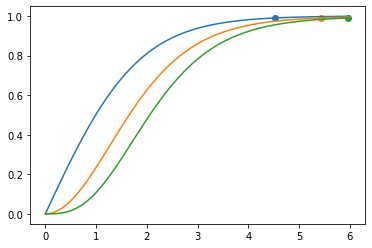

In [79]:
xbar = df.groupby(['A'])[['value']].mean()
xbar = np.array(xbar)
xbar = xbar.flatten()

MS_error = 1025.784722
dof_error = 9
alpha = 0.01

std_error = np.sqrt(MS_error / n)
print("Standard Error = %0.3f" % std_error)

# order the means from smallest to largest

print("Original xbar = ", xbar)
xbar_orig = xbar.copy()
xbar.sort()
print("Sorted xbar = ", xbar)

# get the expected number of error bars (sem) between largest and smallest for
# the number of means to be compared (a). For this, we need the studentized range
# table values q(alpha, dof_error, k) for k=2..a

# http://www.real-statistics.com/statistics-tables/studentized-range-q-table/
# For this problem, dof_error = 15, alpha = 0.05, k = 2,3,4,5
# q = np.array([3.014,3.673,4.076,4.367])

n_means=len(xbar)
q = q_tukey(n_means,dof_error,alpha)
print (q)

# Step 4:  Calculate W = q(k=5)*std_error

W = q[-1]*std_error

print ("W = %0.2f" % W)

# Step 5:  Make pair-wise comparisons

print (list(xbar_orig))

print ("i j xbar1 xbar2 Diff Diff_comp Result")
for i in range(len(xbar)):
    for j in range(len(xbar)):
        if (xbar[j] > xbar[i]):
            diff = (xbar[j] - xbar[i])/std_error
            diff_comp = q[j-i-1]
            if (diff>diff_comp):
                Result = "Yes"
            else:
                Result = "No"
            iorig = list(xbar_orig).index(xbar[i])+1
            jorig = list(xbar_orig).index(xbar[j])+1
            print ("%0.0f %0.0f %0.1f %0.1f %0.3f  %0.3f %s" % (iorig,jorig,xbar[i],xbar[j],diff,diff_comp,Result))

Standard Error = 16.014
Original Xbar =  [336.75 382.25 419.25 473.  ]
Sorted Xbar =  [336.75 382.25 419.25 473.  ]
q_tukey: calculating k =  2
q_critical =  4.524647757521833
q_tukey: calculating k =  3
q_critical =  5.426582159217026
q_tukey: calculating k =  4
q_critical =  5.955182266371887
[4.52464776 5.42658216 5.95518227]
W = 95.37
[336.75, 382.25, 419.25, 473.0]
i j xbar1 xbar2 Diff Diff_comp Result
1 2 336.8 382.2 2.841  4.525 No
1 3 336.8 419.2 5.152  5.427 No
1 4 336.8 473.0 8.508  5.955 Yes
2 3 382.2 419.2 2.310  4.525 No
2 4 382.2 473.0 5.667  5.427 Yes
3 4 419.2 473.0 3.356  4.525 No


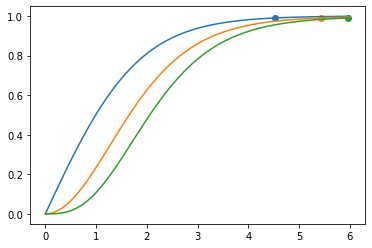

In [73]:
xbar = df.groupby(['B'])[['value']].mean()
xbar = np.array(xbar)
xbar= xbar.flatten()
# Tukey's Procedure
#
# Step 1:  Calculate the standard error = sqrt(MS_error/n)

std_error = np.sqrt(MS_error/n)
print ("Standard Error = %0.3f" % std_error)

# Step 2:  Order the means from smallest to largest

print ("Original Xbar = ",xbar)
xbar_orig = xbar.copy()
xbar.sort()
print ("Sorted Xbar = ",xbar)

# Step 3:  Get the expected number of error bars (sem) between largest and smallest, for the number
# of means to be compared (a).  For this, we need the studentized range table values q(alpha,dof_error,k) for k=2..a.
# 
# http://www.real-statistics.com/statistics-tables/studentized-range-q-table/
# For this problem, dof_error = 15, alpha = 0.05, k = 2,3,4,5
# q = np.array([3.014,3.673,4.076,4.367])

n_means=len(xbar)
q = q_tukey(n_means,dof_error,alpha)
print (q)

# Step 4:  Calculate W = q(k=5)*std_error

W = q[n_means-2]*std_error

print ("W = %0.2f" % W)

# Step 5:  Make pair-wise comparisons

print (list(xbar_orig))

print ("i j xbar1 xbar2 Diff Diff_comp Result")
for i in range(len(xbar)):
    for j in range(len(xbar)):
        if (xbar[j] > xbar[i]):
            diff = (xbar[j] - xbar[i])/std_error
            diff_comp = q[j-i-1]
            if (diff>diff_comp):
                Result = "Yes"
            else:
                Result = "No"
            iorig = list(xbar_orig).index(xbar[i])+1
            jorig = list(xbar_orig).index(xbar[j])+1
            print ("%0.0f %0.0f %0.1f %0.1f %0.3f  %0.3f %s" % (iorig,jorig,xbar[i],xbar[j],diff,diff_comp,Result))

# Question 4

In an experiment to assess the effect of the angle of pull on the force required to cause separation in electrical connectors, four different angles (factor A) were used and each of a sample of five connectors (factor B) was pulled once at each angle. The data appears in the accompanying table.

Does the data suggest that true average separation force is affected by the angle of pull? State and test the appropriate hypotheses at level .01 by first constructing an ANOVA table (SST = 396.08, SSA = 56.12, SSB = 249.19). (Give answers accurate to 2 decimal places and the p-values to 3 decimal places.)

In [14]:
data = np.array([[45.5,1,1],[42.0,1,2],[39.5,1,3],[37.0,1,4],[45.9,1,5],[44.4,2,1],[44.5,2,2],[38.2,2,3],[37.7,2,4],[47.4,2,5],[42.7,3,1],[42.9,3,2],[42.7,3,3],[42.5,3,4],[48.8,3,5],[43.6,4,1],[45.8,4,2],[47.7,4,3],[37.9,4,4],[56.3,4,5]])

df = pd.DataFrame(data, columns=['value', 'A', 'B'])

formula = 'value ~ C(A) + C(B)'
lm = ols(formula, df).fit()
anova_results = anova_lm(lm)
print(anova_results)

# Fail to reject the null hypothesis, there does not appear to be an angle of pull effect.

            df   sum_sq    mean_sq         F    PR(>F)
C(A)       3.0   55.690  18.563333  2.375473  0.121214
C(B)       4.0  247.965  61.991250  7.932765  0.002286
Residual  12.0   93.775   7.814583       NaN       NaN


# Question 5

The article "The Effects of a Pneumatic Stool and a One-Legged Stool on Lower Limb Joint Load and Muscular Activity During Sitting and Rising" (Ergonomics, 1993: 519-535) gives the accompanying data on the effort required of a subject to arise from four different types of stools (Borg Scale).

Perform an analysis of variance using α = .05. (Give answers accurate to 2 decimal places.)



In [37]:
data = np.array([[12,1,1],[10,1,2],[7,1,3],[7,1,4],[8,1,5],[9,1,6],[8,1,7],[7,1,8],[9,1,9],
                 [15,2,1],[14,2,2],[14,2,3],[11,2,4],[11,2,5],[11,2,6],[12,2,7],[11,2,8],[13,2,9],
                 [12,3,1],[13,3,2],[13,3,3],[10,3,4],[8,3,5],[11,3,6],[12,3,7],[8,3,8],[10,3,9],
                 [10,4,1],[12,4,2],[9,4,3],[9,4,4],[7,4,5],[10,4,6],[11,4,7],[7,4,8],[8,4,9]
                ])

df = pd.DataFrame(data, columns=['value', 'A', 'B'])

formula = 'value ~ C(A) + C(B)'
lm = ols(formula, df).fit()
anova_results = anova_lm(lm)
print(anova_results)

a = 4
b = 9
n = 1

N = n * a * b

v_total = N - 1
v_a = a - 1
v_b = b - 1
v_error = v_total - v_a - v_b

alpha = 0.05

fdist_a = stats.f(v_a, v_error)
fhigh_a = fdist_a.ppf(1 - alpha)
print("Critical f-value A = %0.2f" % (fhigh_a))

            df     sum_sq    mean_sq          F        PR(>F)
C(A)       3.0  81.194444  27.064815  22.355641  3.934564e-07
C(B)       8.0  66.500000   8.312500   6.866157  1.060853e-04
Residual  24.0  29.055556   1.210648        NaN           NaN
Critical f-value A = 3.01


# Question 6

In an experiment to assess the effects of curing time (factor A) and type of mix (factor B) on the compressive strength of hardened cement cubes, three different curing times were used in combination with four different mixes, with three observations obtained for each of the 12 curing time-mix combinations. The resulting sums of squares were computed to be SSA = 29,521.1, SSB = 35,170.8, SSE = 97,521.8, and SST = 205,578.5.

(a) Construct an ANOVA table. (Give df as exact integers, SS and MS to 1 decimal place, F to 2 decimal places, and p-values to 3 decimal places.)

(b) Test at level .05 the null hypothesis HoAB: all γij's = 0 (no interaction of factors) against HaAB: at least one γij ≠ 0.

(c) Test at level .05 the null hypothesis HoA: α1 = α2 = α3 = 0 (factor A main effects are absent) against HaA: at least one αi ≠ 0.

(d) Test HoB: β1 = β2 = β3 = β4 = 0 versus HaB: at least one βj ≠ 0 using a level .05 test.

(e) The values of the xi..'s were x1.. = 4010.88, x2.. = 4029.10, and x3.. = 3960.02. Use Tukey's procedure to investigate significant differences among the three curing times. (Give answer accurate to 2 decimal places.)


In [80]:
a = 3
b = 4
n = 3

N = n * a * b

v_total = N - 1
v_a = a - 1
v_b = b - 1
v_ab = (a - 1)*(b - 1)
v_treatment = v_a + v_b + v_ab
v_error = v_total - v_treatment

print("v_a: %0.2f, v_b: %0.2f, v_ab: %0.2f" % (v_a, v_b, v_ab))
print("v_error: %0.2f, v_total: %0.2f" % (v_error, v_total))

v_a: 2.00, v_b: 3.00, v_ab: 6.00
v_error: 24.00, v_total: 35.00


In [81]:
SS_a = 30007.1
SS_b = 33834.3
SS_error = 96325.7
SS_total = 203861.3

SS_ab = SS_total - SS_a - SS_b - SS_error

print("SS_ab = %0.1f" % SS_ab)

SS_ab = 43694.2


In [82]:
MS_a = SS_a/v_a
MS_b = SS_b/v_b
MS_ab = SS_ab/v_ab
MS_error = SS_error/v_error

fSN_a = MS_a/MS_error
fSN_b = MS_b/MS_error
fSN_ab = MS_ab/MS_error

print ("F Signal/Noise A = %0.2f " % fSN_a)

alpha = 0.05

fdist_a = stats.f(v_a,v_error)
fhigh_a = fdist_a.ppf(1-alpha)

print ("Critical F-value A = %0.2f" % (fhigh_a))

if (fSN_a > 1):
    pvalue_a = (1-fdist_a.cdf(fSN_a))
else:
    pvalue_a = fdist_a.cdf(fSN_a)
    
print ("Pvalue A = %0.3f" % (pvalue_a))


print ("F Signal/Noise B = %0.2f " % fSN_b)

fdist_b = stats.f(v_b,v_error)
fhigh_b = fdist_b.ppf(1-alpha)

print ("Critical F-value B = %0.2f" % (fhigh_b))

if (fSN_b > 1):
    pvalue_b = (1-fdist_b.cdf(fSN_b))
else:
    pvalue_b = fdist_b.cdf(fSN_b)
    
print ("Pvalue B = %0.3f" % (pvalue_b))

print ("F Signal/Noise AB = %0.2f " % fSN_ab)

fdist_ab = stats.f(v_ab,v_error)
fhigh_ab = fdist_ab.ppf(1-alpha)

print ("Critical F-value AB = %0.2f" % (fhigh_ab))

if (fSN_ab > 1):
    pvalue_ab = (1-fdist_ab.cdf(fSN_ab))
else:
    pvalue_ab = fdist_ab.cdf(fSN_ab)
    
print ("Pvalue AB = %0.3f" % (pvalue_ab))

# Print table
print()
print ("Source     df     Sum of Squares Mean Square     f     P-value")
print ("A          %0.0f       %0.2f            %0.2f       %0.2f    %0.4f" %(v_a,SS_a,MS_a,fSN_a,pvalue_a))
print ("B          %0.0f       %0.2f           %0.2f       %0.2f    %0.4f" %(v_b,SS_b,MS_b,fSN_b,pvalue_b))
print ("AB         %0.0f       %0.2f           %0.2f       %0.2f    %0.4f" %(v_ab,SS_ab,MS_ab,fSN_ab,pvalue_ab))
print ("Error      %0.0f      %0.2f            %0.2f" %(v_error,SS_error,MS_error))
print ("Total      %0.0f     %0.2f" %(v_total,SS_total))

F Signal/Noise A = 3.74 
Critical F-value A = 3.40
Pvalue A = 0.039
F Signal/Noise B = 2.81 
Critical F-value B = 3.01
Pvalue B = 0.061
F Signal/Noise AB = 1.81 
Critical F-value AB = 2.51
Pvalue AB = 0.139

Source     df     Sum of Squares Mean Square     f     P-value
A          2       30007.10            15003.55       3.74    0.0386
B          3       33834.30           11278.10       2.81    0.0610
AB         6       43694.20           7282.37       1.81    0.1387
Error      24      96325.70            4013.57
Total      35     203861.30


Standard Error = 18.288
Original Xbar =  [4010.88 4029.1  3960.02]
Sorted Xbar =  [3960.02 4010.88 4029.1 ]
q_tukey: calculating k =  2
q_critical =  2.9058174025748973
q_tukey: calculating k =  3
q_critical =  3.5302035366602835
[2.9058174  3.53020354]
W = 64.56
[4010.88, 4029.1, 3960.02]
i j xbar1 xbar2 Diff Diff_comp Result
3 1 3960.0 4010.9 2.781  2.906 No
3 2 3960.0 4029.1 3.777  3.530 Yes
1 2 4010.9 4029.1 0.996  2.906 No


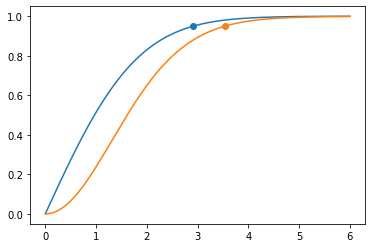

In [83]:
# summary data for xbar
xbar = np.array([4010.88,4029.10,3960.02])
xbarbar = xbar.mean()
n=N/a

# Tukey's Procedure
#
# Step 1:  Calculate the standard error = sqrt(MS_error/n)

std_error = np.sqrt(MS_error/n)
print ("Standard Error = %0.3f" % std_error)

# Step 2:  Order the means from smallest to largest

print ("Original Xbar = ",xbar)
xbar_orig = xbar.copy()
xbar.sort()
print ("Sorted Xbar = ",xbar)

# Step 3:  Get the expected number of error bars (sem) between largest and smallest, for the number
# of means to be compared (a).  For this, we need the studentized range table values q(alpha,dof_error,k) for k=2..a.
# 
# http://www.real-statistics.com/statistics-tables/studentized-range-q-table/
# For this problem, dof_error = 15, alpha = 0.05, k = 2,3,4,5
# q = np.array([3.014,3.673,4.076,4.367])

n_means=len(xbar)
q = q_tukey(n_means,v_error,alpha)
print (q)

# Step 4:  Calculate W = q(k=5)*std_error

W = q[-1]*std_error

print ("W = %0.2f" % W)

# Step 5:  Make pair-wise comparisons

print (list(xbar_orig))

print ("i j xbar1 xbar2 Diff Diff_comp Result")
for i in range(len(xbar)):
    for j in range(len(xbar)):
        if (xbar[j] > xbar[i]):
            diff = (xbar[j] - xbar[i])/std_error
            diff_comp = q[j-i-1]
            if (diff>diff_comp):
                Result = "Yes"
            else:
                Result = "No"
            iorig = list(xbar_orig).index(xbar[i])+1
            jorig = list(xbar_orig).index(xbar[j])+1
            print ("%0.0f %0.0f %0.1f %0.1f %0.3f  %0.3f %s" % (iorig,jorig,xbar[i],xbar[j],diff,diff_comp,Result))

# Question 7

To see whether thrust force in drilling is affected by drilling speed (A), feed rate (B), or material used (C), an experiment using four speeds, three rates, and two materials was performed, with two samples (L = 2) drilled at each combination of levels of the three factors. Sums of squares were calculated as follows: SSA = 19,122.02, SSB = 2,589,419.28, SSC = 158,083.12, SSAB = 52,465.89, SSAC = 9,046.12, SSBC = 92,061.74, and SSE = 57,721.17, and SST = 3,011,312.03. Construct the ANOVA table and identify significant interactions using α = 0.01. (Give SS and MS accurate to 1 decimal place, F values to 2 decimal places, and Df as exact integers.)

In [46]:
# Calculate relevant degrees of freedom
a = 4
b = 3
c = 2
n = 2

N = n * a * b * c

v_total = N - 1
v_a = a - 1
v_b = b - 1
v_c = c - 1
v_ab = (a - 1)*(b - 1)
v_ac = (a - 1)*(c - 1)
v_bc = (b - 1)*(c - 1)
v_abc = (a - 1)*(b - 1)*(c - 1)

v_treatment = v_a + v_b + v_c + v_ab + v_ac + v_bc + v_abc
v_error = v_total - v_treatment

print("v_a: %0.2f, v_b: %0.2f, v_c: %0.2f,\nv_ab: %0.2f, v_ac: %0.2f, v_bc: %0.2f, v_abc: %0.2f\nv_error: %i\nv_total: %i" % (v_a, v_b, v_c, v_ab, v_ac, v_bc, v_abc, v_error, v_total))

v_a: 3.00, v_b: 2.00, v_c: 1.00,
v_ab: 6.00, v_ac: 3.00, v_bc: 2.00, v_abc: 6.00
v_error: 24
v_total: 47


In [47]:
# Sums of squares
SS_a = 19132.76
SS_b = 2588564.85
SS_c = 157803.76
SS_ab = 52133.67
SS_ac = 9028.85
SS_bc = 92843.99
SS_error = 57125.94
SS_total = 3021363.78

SS_abc = SS_total - SS_a - SS_b - SS_c - SS_ab - SS_ac - SS_bc - SS_error

print("SS_abc: %0.2f" % SS_abc)

SS_abc: 44729.96


In [53]:
MS_a = SS_a / v_a
MS_b = SS_b / v_b
MS_c = SS_c / v_c
MS_ab = SS_ab / v_ab
MS_ac = SS_ac / v_ac
MS_bc = SS_bc / v_bc
MS_abc = SS_abc / v_abc
MS_error = SS_error / v_error

print("MS error A = %0.1f" % MS_a)
print("MS error B = %0.1f" % MS_b)
print("MS error C = %0.1f" % MS_c)
print("MS error AB = %0.1f" % MS_ab)
print("MS error AC = %0.1f" % MS_ac)
print("MS error BC = %0.1f" % MS_bc)
print("MS error ABC = %0.1f" % MS_abc)
print("MS error = %0.1f" % MS_error)
print()

fSN_a = MS_a / MS_error
fSN_b = MS_b / MS_error
fSN_c = MS_c / MS_error
fSN_ab = MS_ab / MS_error
fSN_ac = MS_ac / MS_error
fSN_bc = MS_bc / MS_error
fSN_abc = MS_abc / MS_error

print("F Signal/Noise A = %0.2f" % fSN_a)
print("F Signal/Noise B = %0.2f" % fSN_b)
print("F Signal/Noise C = %0.2f" % fSN_c)
print("F Signal/Noise AB = %0.2f" % fSN_ab)
print("F Signal/Noise AC = %0.2f" % fSN_ac)
print("F Signal/Noise BC = %0.2f" % fSN_bc)
print("F Signal/Noise ABC = %0.2f" % fSN_abc)

MS error A = 6377.6
MS error B = 1294282.4
MS error C = 157803.8
MS error AB = 8688.9
MS error AC = 3009.6
MS error BC = 46422.0
MS error ABC = 7455.0
MS error = 2380.2

F Signal/Noise A = 2.68
F Signal/Noise B = 543.76
F Signal/Noise C = 66.30
F Signal/Noise AB = 3.65
F Signal/Noise AC = 1.26
F Signal/Noise BC = 19.50
F Signal/Noise ABC = 3.13


# Question 8

In an automated chemical coating process, the speed with which objects on a conveyor belt are passed through a chemical spray (belt speed), the amount of chemical sprayed (spray volume), and the brand of chemical used (brand) are factors that may affect the uniformity of the coating applied. A replicated $2^3$ experiment was conducted in an effort to increase the coating uniformity. In the following table, higher values of the response variable are associated with higher surface uniformity.

Analyze this data and state your conclusions. Let A = spray volume, B = belt speed, C = brand. (Use α = 0.05. Give answers accurate to 2 decimal places and Df as exact integers.)

In [56]:
data = np.array([[40,1,1,1],[25,2,1,1],[30,1,2,1],[50,2,2,1],
                 [45,1,1,2],[25,2,1,2],[30,1,2,2],[52,2,2,2],
                 [36,1,1,1],[28,2,1,1],[32,1,2,1],[48,2,2,1],
                 [43,1,1,2],[30,2,1,2],[29,1,2,2],[49,2,2,2]])

df = pd.DataFrame(data, columns=['value','SP','BS','BR'])

df.head(1000)

formula = 'value ~ C(SP) + C(BS) + C(BR) + C(SP):C(BS) + C(SP):C(BR) + C(BS):C(BR) + C(SP):C(BS):C(BR)'
lm = ols(formula,df).fit()
anovaResults = anova_lm(lm)
print (anovaResults)

                    df   sum_sq  mean_sq           F        PR(>F)
C(SP)              1.0    30.25    30.25    6.722222  3.197737e-02
C(BS)              1.0   144.00   144.00   32.000000  4.776141e-04
C(BR)              1.0    12.25    12.25    2.722222  1.375685e-01
C(SP):C(BS)        1.0  1122.25  1122.25  249.388889  2.584228e-07
C(SP):C(BR)        1.0     1.00     1.00    0.222222  6.499402e-01
C(BS):C(BR)        1.0    12.25    12.25    2.722222  1.375685e-01
C(SP):C(BS):C(BR)  1.0    16.00    16.00    3.555556  9.607159e-02
Residual           8.0    36.00     4.50         NaN           NaN


In [58]:
a = 4
b = 9
n = 2

N = n * a * b

v_total = N - 1
v_a = a - 1
v_b = b - 1
v_error = v_total - v_a - v_b

alpha = 0.05

fdist_a = stats.f(v_a, v_error)
fhigh_a = fdist_a.ppf(1 - alpha)
print("Critical f-value A = %0.2f" % (fhigh_a))

Critical f-value A = 2.76
